# Logistic Regression Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support, make_scorer, fbeta_score, RocCurveDisplay, DetCurveDisplay, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

np.random.seed(1000)

## Load Data

In [2]:
def read_dataset(name):
  df_train = pd.read_csv(f"../data/modeling/data_{name}_train.csv")
  df_test = pd.read_csv(f"../data/modeling/data_{name}_test.csv")

  X_train = df_train.drop(columns="Abnormal")
  X_test = df_test.drop(columns="Abnormal")
  y_train = df_train.Abnormal
  y_test = df_test.Abnormal

  return X_train, X_test, y_train, y_test

X_1da_train, X_1da_test, y_train, y_test = read_dataset("1da")
X_reduced_train, X_reduced_test, _, _ = read_dataset("reduced")
X_expanded_train, X_expanded_test, _, _ = read_dataset("expanded")

## Model Configuration

In [3]:
train_features = {
  "lr_1da": X_1da_train,
  "lr_red": X_reduced_train,
  "lr_exp": X_expanded_train,
  "lr_pca_1da": X_1da_train,
  "lr_pca_red": X_reduced_train,
  "lr_pca_exp": X_expanded_train,
  "lr_ridge_1da": X_1da_train,
  "lr_ridge_red": X_reduced_train,
  "lr_ridge_exp": X_expanded_train,
}

test_features = {
  "lr_1da": X_1da_test,
  "lr_red": X_reduced_test,
  "lr_exp": X_expanded_test,
  "lr_pca_1da": X_1da_test,
  "lr_pca_red": X_reduced_test,
  "lr_pca_exp": X_expanded_test,
  "lr_ridge_1da": X_1da_test,
  "lr_ridge_red": X_reduced_test,
  "lr_ridge_exp": X_expanded_test,
}

model_configs = {
  "lr_1da": {
    "clf": LogisticRegression(n_jobs=-1),
    "param_grid": {}
  },
  "lr_red": {
    "clf": LogisticRegression(n_jobs=-1),
    "param_grid": {}
  },
  "lr_exp": {
    "X": X_expanded_train,
    "clf": LogisticRegression(n_jobs=-1),
    "param_grid": {}
  },
  "lr_pca_1da": {
    "clf": LogisticRegression(n_jobs=-1),
    "param_grid": {"pca__n_components": [i for i in range(1, X_1da_train.shape[1]+1)]}
  },
  "lr_pca_red": {
    "clf": LogisticRegression(n_jobs=-1),
    "param_grid": {"pca__n_components": [i for i in range(1, X_reduced_train.shape[1]+1)]}
  },
  "lr_pca_exp": {
    "clf": LogisticRegression(n_jobs=-1),
    "param_grid": {"pca__n_components": [i for i in range(1, X_expanded_train.shape[1]+1)]}
  },
  "lr_ridge_1da": {
    "clf": LogisticRegression(n_jobs=-1, max_iter=10000, penalty="l2", solver="saga"),
    "param_grid": {
      "clf__C": [1*10**p for p in range(-4, 4)],
      "clf__fit_intercept": [False, True],
    }
  },
  "lr_ridge_red": {
    "clf": LogisticRegression(n_jobs=-1, max_iter=10000, penalty="l2", solver="saga"),
    "param_grid": {
      "clf__C": [1*10**p for p in range(-4, 4)],
      "clf__fit_intercept": [False, True],
    }
  },
  "lr_ridge_exp": {
    "clf": LogisticRegression(n_jobs=-1, max_iter=10000, penalty="l2", solver="saga"),
    "param_grid": {
      "clf__C": [1*10**p for p in range(-4, 4)],
      "clf__fit_intercept": [False, True],
    }
  },
}

## Training

In [4]:
def perform_grid_search_fit(model_config, X_fit, y_fit):
  clf = model_config["clf"]
  param_grid = model_config["param_grid"]

  pipe_steps = [
    ("scaler", StandardScaler()),
    ("clf", clf)
  ]

  if "pca" in name:
    pipe_steps.insert(1, ("pca", PCA()))

  pipe = Pipeline(pipe_steps)
  kf = StratifiedKFold(n_splits=10)
  search = GridSearchCV(pipe, param_grid, cv=kf, scoring=make_scorer(fbeta_score, beta=2), n_jobs=-1, refit=True)
  search.fit(X_fit, y_fit)

  return (search.best_estimator_, search.best_params_)

best_models = {}
for name, model_config in model_configs.items():
  X_train = train_features[name]
  best_model, best_params = perform_grid_search_fit(model_config, X_train, y_train)
  print(f"Best params for model {name}: {best_params}")
  best_models[name] = {
    "model": best_model,
    "params": best_params
  }

Best params for model lr_1da: {}
Best params for model lr_red: {}
Best params for model lr_exp: {}
Best params for model lr_pca_1da: {'pca__n_components': 11}
Best params for model lr_pca_red: {'pca__n_components': 9}
Best params for model lr_pca_exp: {'pca__n_components': 51}
Best params for model lr_ridge_1da: {'clf__C': 10, 'clf__fit_intercept': False}
Best params for model lr_ridge_red: {'clf__C': 0.1, 'clf__fit_intercept': False}
Best params for model lr_ridge_exp: {'clf__C': 1000, 'clf__fit_intercept': False}


## Fitted Coefficients

In [17]:
betas_df = pd.DataFrame(index=X_expanded_train.columns)
for name, best_model in best_models.items():
  mod = best_model["model"]
  params = best_model["params"]
  X_train = train_features[name]

  if "pca" not in name:
    betas = mod.named_steps["clf"].coef_
    betas = pd.Series(betas[0], index=X_train.columns, name=name)
    betas_df = betas_df.merge(betas, how="left", left_index=True, right_index=True)
display(betas_df)

,lr_1da,lr_red,lr_exp,lr_ridge_1da,lr_ridge_red,lr_ridge_exp
ACWO_1,-0.092011,-0.091056,1.610988,-0.093806,-0.013684,1.921379
ACWO_2,NaN,NaN,-1.316799,NaN,NaN,-2.073412
ACWO_3,NaN,NaN,-0.759526,NaN,NaN,-0.582469
ACWO_4,NaN,NaN,1.056699,NaN,NaN,1.573601
ACWO_5,NaN,NaN,-1.908907,NaN,NaN,-1.718522
ACWO_6,NaN,NaN,1.296970,NaN,NaN,0.845987
ADMO_1,0.072352,-0.007721,-0.142532,0.083644,0.005575,-0.365524
ADMO_2,NaN,NaN,1.199897,NaN,NaN,1.494634
ADMO_3,NaN,NaN,-1.013792,NaN,NaN,-0.944140
ADMO_4,NaN,NaN,-0.506284,NaN,NaN,-0.883626


## Threshold Selection

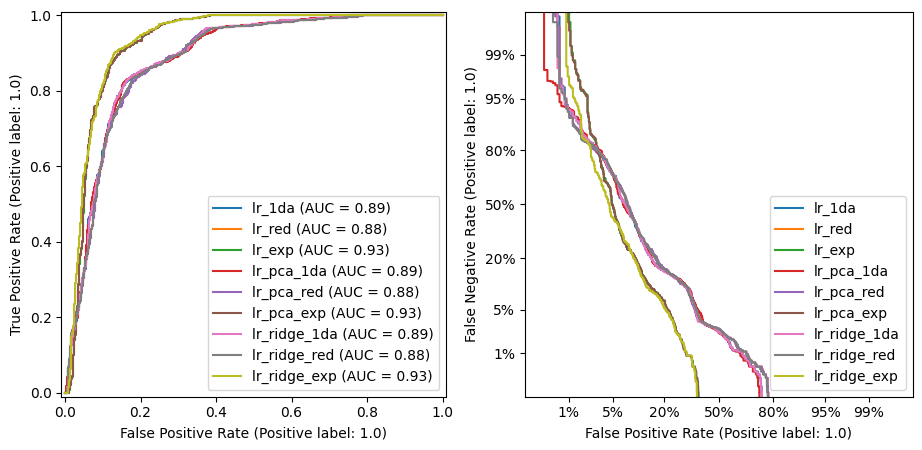

In [5]:
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

for name, best_model in best_models.items():
  mod = best_model["model"]
  params = best_model["params"]
  X_train = train_features[name]
 
  RocCurveDisplay.from_estimator(mod, X_train, y_train, ax=ax_roc, name=name)
  DetCurveDisplay.from_estimator(mod, X_train, y_train, ax=ax_det, name=name)

In [6]:
mod_thresh = {}
for name, best_model in best_models.items():
  mod = best_model["model"]
  X_train = train_features[name]
  y_prob = mod.predict_proba(X_train)[:,1]
  
  t_iter = []
  f2_iter = []

  thres = [x/100 for x in np.linspace(0, 100, 101)]
  opt_thres = -1
  max_f2 = -1
  for t in thres:
    pred_y = [0 if p < t else 1 for p in y_prob]
    prec, rec, f2, _ = precision_recall_fscore_support(y_train, pred_y, beta=2, average="binary", zero_division=0)
    if f2 > max_f2: 
      max_f2 = f2
      opt_thres = t
      
  print(f"{name} - Opt thresh: {opt_thres}")
  mod_thresh[name] = opt_thres

lr_1da - Opt thresh: 0.26
lr_red - Opt thresh: 0.28
lr_exp - Opt thresh: 0.22
lr_pca_1da - Opt thresh: 0.24
lr_pca_red - Opt thresh: 0.28
lr_pca_exp - Opt thresh: 0.22
lr_ridge_1da - Opt thresh: 0.29
lr_ridge_red - Opt thresh: 0.28
lr_ridge_exp - Opt thresh: 0.27


## Test Evaluation

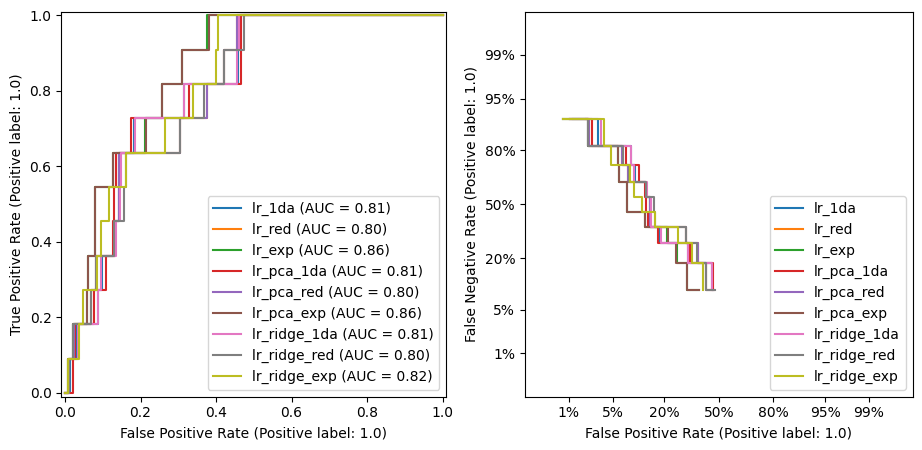

In [18]:
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

for name, best_model in best_models.items():
  mod = best_model["model"]
  params = best_model["params"]
  X_test = test_features[name]
 
  RocCurveDisplay.from_estimator(mod, X_test, y_test, ax=ax_roc, name=name)
  DetCurveDisplay.from_estimator(mod, X_test, y_test, ax=ax_det, name=name)

lr_1da - precision: 0.03273, recall: 0.8182, f2: 0.1411
lr_red - precision: 0.03053, recall: 0.7273, f2: 0.1307
lr_exp - precision: 0.04265, recall: 0.8182, f2: 0.1765
lr_pca_1da - precision: 0.03072, recall: 0.8182, f2: 0.1335
lr_pca_red - precision: 0.03053, recall: 0.7273, f2: 0.1307
lr_pca_exp - precision: 0.04265, recall: 0.8182, f2: 0.1765
lr_ridge_1da - precision: 0.03383, recall: 0.8182, f2: 0.1452
lr_ridge_red - precision: 0.02899, recall: 0.7273, f2: 0.125
lr_ridge_exp - precision: 0.03756, recall: 0.7273, f2: 0.1556


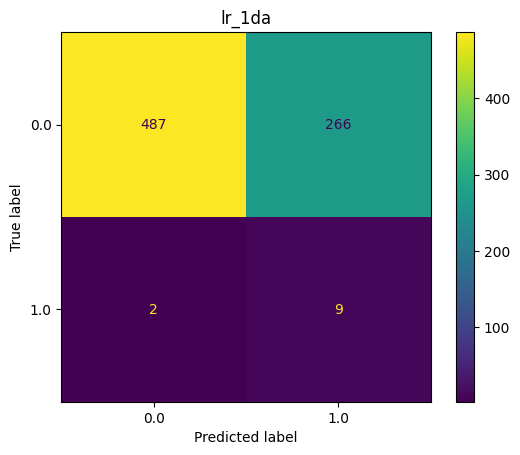

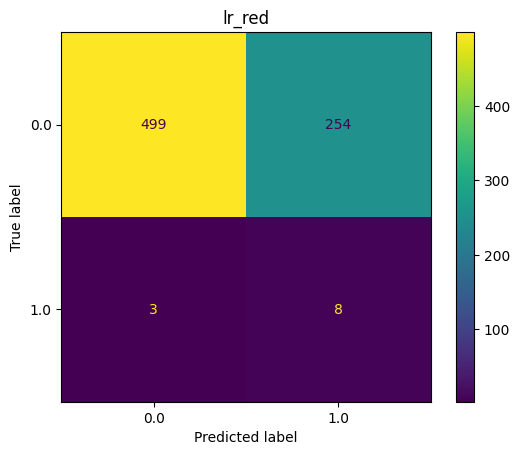

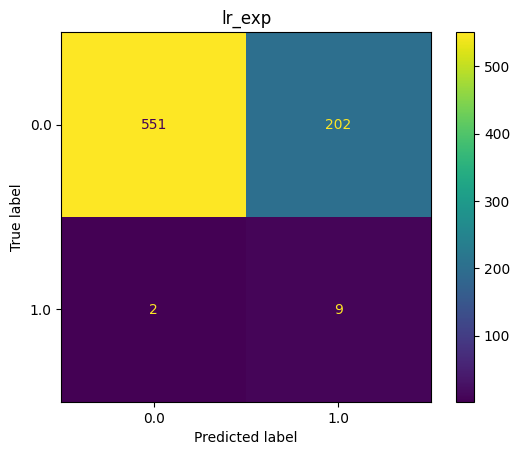

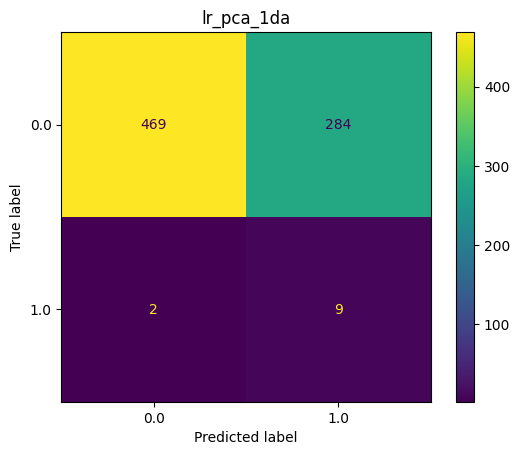

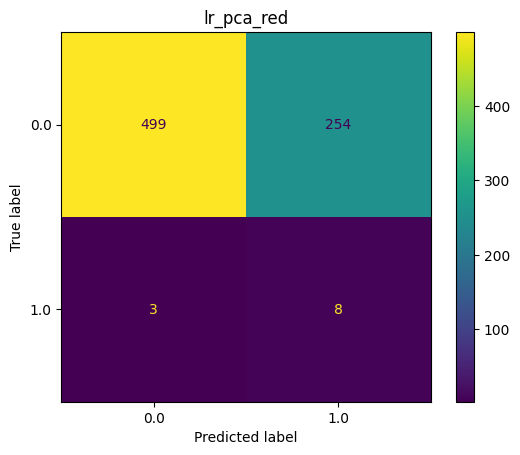

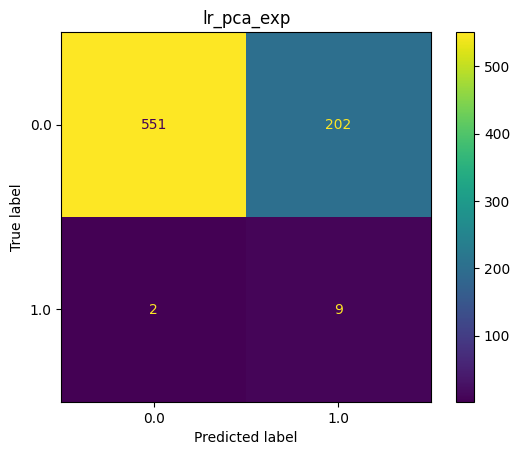

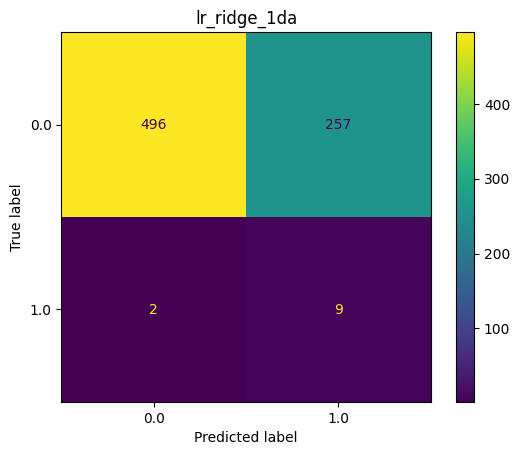

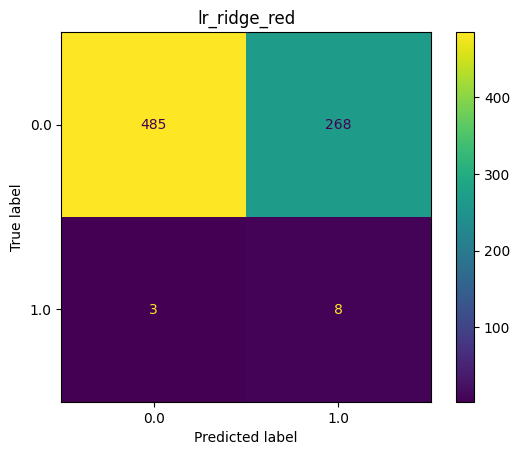

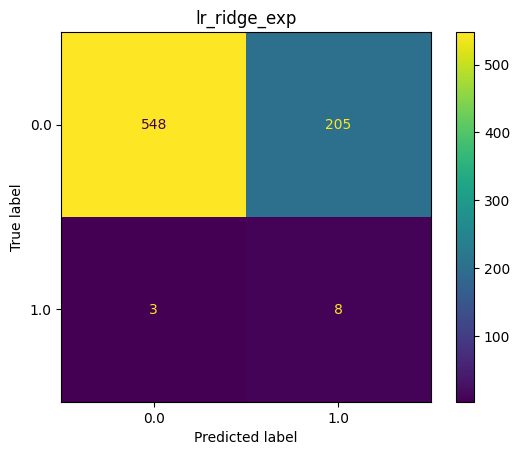

In [23]:
for name, best_model in best_models.items():
  mod = best_model["model"]
  X_test = test_features[name]

  test_prob = mod.predict_proba(X_test)[:,1]
  test_pred = [0 if p < mod_thresh[name] else 1 for p in test_prob]

  p, r, f2, supp = precision_recall_fscore_support(y_test, test_pred, average="binary", beta=2, pos_label=1.0, zero_division=0)
  print(f"{name} - precision: {p:.4}, recall: {r:.4}, f2: {f2:.4}")

  disp = ConfusionMatrixDisplay.from_predictions(y_test, test_pred)
  disp.ax_.set_title(name)